In [1]:
import os
import time
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import spectral
import spectral.io.envi as envi
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix)
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import (Conv3D, Dense, Dropout, Flatten, Input, concatenate, Reshape)
from tensorflow.keras import regularizers
from tensorflow.keras import layers, Model
from keras.losses import categorical_crossentropy
from keras.models import Model, Sequential
from tensorflow.keras.layers import (Activation, Lambda, multiply)
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from operator import truediv
from keras.utils import to_categorical

2024-09-14 10:39:06.970695: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-14 10:39:07.005238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 10:39:07.005278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 10:39:07.006162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-14 10:39:07.013083: I tensorflow/core/platform/cpu_feature_guar

**Load HSI Datasets**

In [2]:
## Loading Datasets
def LoadHSIData(method):
    data_path = os.path.join(os.getcwd(),'../HSI/')
    if method == 'PU':
        HSI = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        GT = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
        Num_Classes = 9
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted','Soil','Bitumen',
                        'Bricks','Shadows']
    elif method == 'SA':
        HSI = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        GT = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
        Num_Classes = 16
        target_names = ['Weeds_1','Weeds_2','Fallow',
                        'Fallow_rough_plow','Fallow_smooth', 'Stubble','Celery',
                        'Grapes_untrained','Soil_vinyard_develop','Corn_Weeds',
                        'Lettuce_4wk','Lettuce_5wk','Lettuce_6wk',
                        'Lettuce_7wk', 'Vinyard_untrained','Vinyard_trellis']
    elif method == 'UH':
      HSI = sio.loadmat(os.path.join(data_path, 'HU.mat'))['HSI']
      GT = sio.loadmat(os.path.join(data_path, 'HU_gt.mat'))['gt']
      Num_Classes = 15
      target_names = ['Healthy grass', 'Stressed grass', 'Synthetic grass', 'Trees',
                    'Soil', 'Water', 'Residential', 'Commercial', 'Road',
                    'Highway', 'Railway', 'Parking Lot 1', 'Parking Lot 2',
                    'Tennis Court', 'Running Track']
    return HSI, GT, Num_Classes, target_names

**Important Internal Functions**

In [3]:
## Prediction Model
def PreModel(Actual, model):
  ## Validation Prediction Model
  prediction = model.predict(Actual)
  argmax_prediction = np.argmax(prediction, axis=1) + 1  # Add 1 to the argmax result to shift the class labels
  non_zero_classes = np.unique(argmax_prediction)  # Get the unique non-zero class labels
  # Remove the 0 class label if it exists in the non_zero_classes array
  if 0 in non_zero_classes:
    non_zero_classes = non_zero_classes[non_zero_classes != 0]
  # Filter out the non-zero classes from the argmax_prediction array
  Pre = argmax_prediction[np.isin(argmax_prediction, non_zero_classes)]
  return Pre

## Computing the Accuracies and Confusion Matrix for Disjoint Samples
def ClassificationReports(TeC, HSID, Te_Pre, target_names):
  classification = classification_report(np.argmax(TeC, axis=1)+1, Te_Pre, target_names = target_names)
  oa = accuracy_score(np.argmax(TeC, axis=1)+1, Te_Pre)
  oa = round(oa, 4)
  confusion = confusion_matrix(np.argmax(TeC, axis=1)+1, Te_Pre)
  list_diag = np.diag(confusion)
  list_raw_sum = np.sum(confusion, axis=1)
  each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
  aa = np.mean(each_acc)
  aa = round(aa, 4)
  kappa = cohen_kappa_score(np.argmax(TeC, axis=1)+1, Te_Pre)
  kappa = round(kappa, 4)
  return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100


## Writing Results in CSV files
def CSVResults(file_name, Tr_Time, Te_Time, Te_classification,
               Te_Confusion, Te_Kappa, Te_OA, Te_AA, Te_Per_Class):
    Te_classification = str(Te_classification)
    Te_Confusion = str(Te_Confusion)
    with open(file_name, 'w') as CSV_file:
      CSV_file.write('{} Tr_Time'.format(Tr_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te_Time'.format(Te_Time))
      CSV_file.write('\n')
      CSV_file.write('{} Te Kappa (%)'.format(Te_Kappa))
      CSV_file.write('\n')
      CSV_file.write('{} Te Overall (%)'.format(Te_OA))
      CSV_file.write('\n')
      CSV_file.write('{} Te Average (%)'.format(Te_AA))
      CSV_file.write('\n')
      CSV_file.write('{} Te Classification'.format(Te_classification))
      CSV_file.write('\n')
      CSV_file.write('{} Te Per Class'.format(Te_Per_Class))
      CSV_file.write('\n')
      CSV_file.write('{} Te Confussion'.format(Te_Confusion))
      CSV_file.write('\n')
    return CSV_file

**Initializating Parameters**

In [4]:
## Global Parameters for Loop
HSID = "UH" ## UH, PU, SA
WS = 8
teRatio = 0.50
vrRatio = 0.50
k = 15
adam = tf.keras.optimizers.legacy.Adam(lr = 0.0001, decay = 1e-06)
epochs = 50
batch_size = 56

/home/ahmad/miniconda3/envs/hsi/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


**Dimensionality Reduction and 3D Patch Process**

In [5]:
## Different Dimensional Reduction Methods
def DLMethod(HSI, NC = 75):
  RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
  pca = PCA(n_components = NC, whiten = True)
  RHSI = pca.fit_transform(RHSI)
  RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
  return RHSI

## Creat Patches for 3D (Spatial-Spectral) Models
def ImageCubes(HSI, GT, WS=WS, removeZeroLabels=True):
    num_rows, num_cols, num_bands = HSI.shape
    margin = int(WS / 2)
    padded_data = np.pad(HSI, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    image_cubes = np.zeros((num_rows * num_cols, WS, WS, num_bands))
    patchesLabels = np.zeros((num_rows * num_cols))
    patchIndex = 0
    for r in range(margin, num_rows + margin):
        for c in range(margin, num_cols + margin):
            cube = padded_data[r - margin: r + margin, c - margin: c + margin, :]
            image_cubes[patchIndex, :, :, :] = cube
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    return image_cubes, patchesLabels

**Preprocessing**

In [6]:
## Main Function to load Datasets, Dimensional Reduction and Creating Patchs for CNN
HSI, GT, Num_Classes, target_names = LoadHSIData(HSID)
## Reduce the Dimensionality
start = time.time()
RDHSI = DLMethod(HSI, NC = k)
end = time.time()
DL_Time = end - start
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)

**Disjoint Train/Validation/Test Sample Selection**

In [7]:
## Set seed for reproducibility
np.random.seed(42)
## Calculate the number of rows for each sample
num_rows, num_cols = GT.shape
## Flatten the matrix into a 1D array
flattened = GT.flatten()
## Get the unique values and their counts, excluding the 0 class
unique_values, value_counts = np.unique(flattened, return_counts=True)
nonzero_indices = np.where(unique_values != 0)[0]
unique_values = unique_values[nonzero_indices]
## Create a DataFrame to store sample counts
Samples = pd.DataFrame(columns=['Training', 'Validation', 'Test'])
## Create lists to store the indices
TrInd = []
VaInd = []
TeInd = []
## Split the data for each class
for value in unique_values:
    class_indices = np.where(flattened == value)[0]
    train_indices, test_indices = train_test_split(class_indices, test_size=teRatio)
    train_indices, val_indices = train_test_split(train_indices, test_size=vrRatio)
    ## Save the sample counts
    Samples.loc[value] = [len(train_indices), len(val_indices), len(test_indices)]
    ## Store the indices
    TrInd.extend(train_indices)
    VaInd.extend(val_indices)
    TeInd.extend(test_indices)

## Convert the DataFrame to a CSV file
file_name = f"{HSID}_{teRatio}_{vrRatio}_{k}_{WS}_Samples.csv"
Samples.to_csv(file_name, index_label='Class')
## Reshape the selected samples back into the GT size
train_matrix = np.zeros_like(GT)
val_matrix = np.zeros_like(GT)
test_matrix = np.zeros_like(GT)
## Convert Train/Validation/Test samples into Matrix
train_matrix.flat[TrInd] = 1
val_matrix.flat[VaInd] = 1
test_matrix.flat[TeInd] = 1
## Select Train/Validation/Test Samples
Tr = CRDHSI[TrInd]
Va = CRDHSI[VaInd]
Te = CRDHSI[TeInd]
## Convert labels into one-hot encoding
TrC = to_categorical(CGT[TrInd] -1)
VaC = to_categorical(CGT[VaInd] -1)
TeC = to_categorical(CGT[TeInd] -1)

In [8]:
# Define the Pyramid 3D CNN model
def pyramid_3d_cnn(WS, k, num_pyramid_levels):
    input_shape = (WS, WS, k, 1)
    max_patch_size = min(input_shape[:3])
    patch_size = max_patch_size
    inputs = layers.Input(shape=input_shape)
    x = inputs
    # Create pyramid levels
    pyramid_outputs = []
    # Create pyramid levels
    for level in range(num_pyramid_levels):
        scale = 2 ** level
        scaled_input_shape = (input_shape[0] // scale, input_shape[1] // scale, input_shape[2] // scale, input_shape[3])
        # Convolutional layers for each pyramid level
        x = tf.keras.layers.Conv3D(32, kernel_size=(1, patch_size, patch_size), activation='relu', padding='same', input_shape=scaled_input_shape)(x)
        x = tf.keras.layers.Conv3D(64, kernel_size=(1, patch_size, patch_size), activation='relu', padding='same')(x)
        pyramid_outputs.append(x)

    # Merge the feature maps from pyramid levels
    merged = tf.keras.layers.concatenate(pyramid_outputs, axis=-1)
    return Model(inputs=inputs, outputs=merged)

def PyFormer(WS, k, num_classes):
    num_layers = 2
    num_heads = 4
    mlp_dim = 64
    num_pyramid_levels = 2
    input_shape = (WS, WS, k, 1)
    inputs = layers.Input(shape=input_shape)
    x = pyramid_3d_cnn(WS, k, num_pyramid_levels)(inputs)
    x = layers.Activation("relu")(x)
    for i in range(num_layers):
        x = layers.LayerNormalization()(x)
        x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=k)(x, x)
        x = layers.Add()([x, inputs])
        y = layers.Conv3D(filters=k, kernel_size=(1, WS, WS), activation='relu', padding='same')(x)
        y = layers.Conv3D(filters=2*mlp_dim, kernel_size=(1, WS, WS), activation='relu', padding='same')(y)
        x = layers.Add()([x, y])
    # Apply regularization
    flatten_layer = layers.Flatten()(x)
    x = layers.Dense(units=128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(flatten_layer)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs, name='PyFormer')
    return model

In [9]:
def train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC, adam,
                             CRDHSI, HSID, teRatio, k, WS, RDHSI,
                             GT,Num_Classes,batch_size,epochs, val_matrix,
                             VaInd, test_matrix, TeInd, flattened):
  # Calling Custom Model
  model = model_name(WS, k, Num_Classes)
  model.summary()
  # Compiling the model
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  # Training the model
  start = time.time()
  history = model.fit(x=Tr, y=TrC, batch_size=batch_size, epochs=epochs, validation_data=(Va, VaC))
  end = time.time()
  Tr_Time = end - start

  ## Test Prediction Model
  start = time.time()
  Te_Pre = PreModel(Te, model)
  end = time.time()
  Te_Time = end - start

  ## Transform The Test Predicted Labels into GTs for Final Plot
  Te_labels = Tranform_Labels(test_matrix, TeInd, Te_Pre)

  ## Classification Report for Test Model
  Te_classification,Te_Confusion,Te_OA,Te_Per_Class,Te_AA,Te_Kappa = ClassificationReports(TeC, HSID, Te_Pre, target_names)
  Te_Kappa = round(Te_Kappa, 4)
  ## Writing Results in CSV File
  file_name = f"{HSID}_{teRatio}_{vrRatio}_{WS}_{model_name}_Classification_Report.csv"
  CSV_file = CSVResults(file_name, Tr_Time, Te_Time, Te_classification, Te_Confusion,
                        Te_Kappa, Te_OA, Te_AA, Te_Per_Class)

  ## Print Ground Truths
  cmap = 'jet'
  plt.figure(figsize=(8, 8))
  plt.imshow(Te_labels, cmap=cmap, interpolation='nearest')
  plt.title(f'Dis_Test: {Te_Kappa}%', fontsize=10, fontweight='bold')
  plt.axis('off')
  plt.tight_layout()
  ## Save the plot
  file_name = f"{HSID}_{teRatio}_{vrRatio}_{WS}_{model_name}_Predicted_GTs.png"
  plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)
  return history

2024-09-14 10:39:28.477215: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 10:39:28.499938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 10:39:28.499979: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 10:39:28.510870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-14 10:39:28.510964: I external/local_xla/xla/stream_executor

Model: "PyFormer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 8, 15, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 8, 8, 15, 128)        395456    ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 8, 8, 15, 128)        0         ['model[0][0]']               
                                                                                                  
 layer_normalization (Layer  (None, 8, 8, 15, 128)        256       ['activation[0][0]']          
 Normalization)                                                                            

2024-09-14 10:39:32.222907: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-09-14 10:39:32.410251: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-14 10:39:32.505554: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


68/68 [==============================] - 71s 886ms/step - loss: 3.1620 - accuracy: 0.8817 - val_loss: 2.6957 - val_accuracy: 0.9572
Epoch 2/50
68/68 [==============================] - 54s 798ms/step - loss: 2.5065 - accuracy: 0.9805 - val_loss: 2.5131 - val_accuracy: 0.9617
Epoch 3/50
68/68 [==============================] - 54s 795ms/step - loss: 2.2052 - accuracy: 0.9920 - val_loss: 2.1354 - val_accuracy: 0.9798
Epoch 4/50
68/68 [==============================] - 54s 796ms/step - loss: 1.9840 - accuracy: 0.9891 - val_loss: 1.9023 - val_accuracy: 0.9824
Epoch 5/50
68/68 [==============================] - 54s 795ms/step - loss: 1.7299 - accuracy: 0.9949 - val_loss: 1.7100 - val_accuracy: 0.9808
Epoch 6/50
68/68 [==============================] - 54s 797ms/step - loss: 1.5579 - accuracy: 0.9907 - val_loss: 1.5779 - val_accuracy: 0.9774
Epoch 7/50
68/68 [==============================] - 54s 794ms/step - loss: 1.5181 - accuracy: 0.9782 - val_loss: 1.4978 - val_accuracy: 0.9649
Epoch 8/50

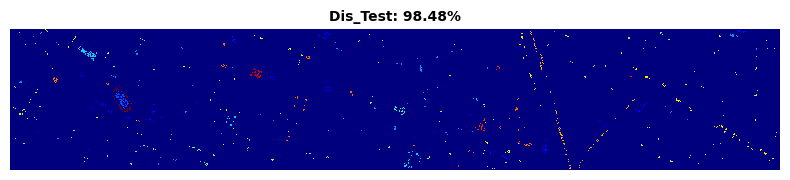

In [10]:
# # Define a list of model names
# model_names = [AttentionGCN, Xtreme_Exception, HybIN, SCSNet, PyFormer]
model_names = [PyFormer]
# Loop over the model names and run train_and_evaluate_model() for each model
history_list = []
for model_name in model_names:
    history = train_and_evaluate_model(model_name, Tr, TrC, Va, VaC, Te, TeC,
                                       adam, CRDHSI, HSID, teRatio, k, WS,
                                       RDHSI, GT, Num_Classes, batch_size,
                                       epochs, val_matrix, VaInd,
                                       test_matrix, TeInd, flattened)
    history_list.append(history)

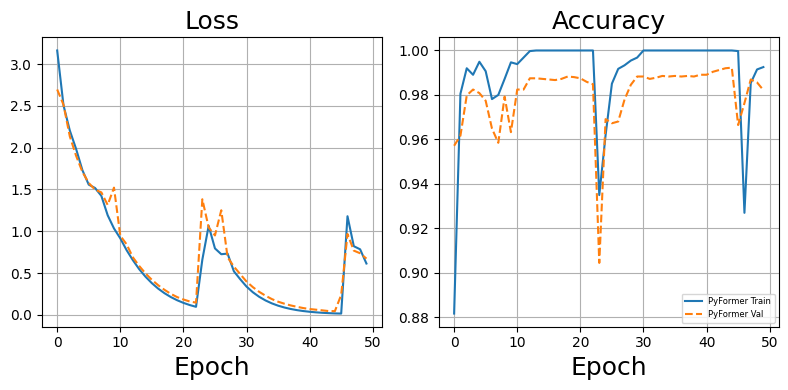

In [11]:
# Plot training and validation loss and accuracy for each model on one graph
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# colors = ['brown', 'gray', 'blue', 'green', 'purple', 'orange', 'yellow', 'red', 'YlOrBr', 'RdPu', 'YlGn']

for i, history in enumerate(history_list):
    # Plot loss
    axs[0].plot(history.history['loss'], label=f'{model_names[i].__name__} Train')
    axs[0].plot(history.history['val_loss'], label=f'{model_names[i].__name__} Val', linestyle='--')
    # Plot accuracy
    axs[1].plot(history.history['accuracy'], label=f'{model_names[i].__name__} Train')
    axs[1].plot(history.history['val_accuracy'], label=f'{model_names[i].__name__} Val', linestyle='--')
# Add labels and legend
axs[0].set_title('Loss', fontsize=18)
axs[0].set_xlabel('Epoch', fontsize=18)
# axs[0].set_ylabel('Loss', fontsize=18)
# axs[0].legend(fontsize=18)

axs[1].set_title('Accuracy', fontsize=18)
axs[1].set_xlabel('Epoch', fontsize=18)
# axs[1].set_ylabel('Accuracy', fontsize=18)
axs[1].legend(fontsize=6)

# Add grid lines and set background color
axs[0].grid(True)
axs[1].grid(True)
# fig.patch.set_facecolor('#f2f2f2')
plt.tight_layout()
file_name = f"{HSID}_{teRatio}_{k}_{WS}_acc_loss_curve_all_models.png"
plt.savefig(file_name, dpi=500, format='png', bbox_inches='tight', pad_inches=0)